In [1]:
import os

# --- ！！！网络代理设置！！！ ---
# 在这里设置您的HTTP和HTTPS代理。
# 这个设置只会影响当前这个Python脚本的运行。
# 请将 '127.0.0.1:7890' 替换为您自己的代理地址和端口。
proxy_url = 'http://127.0.0.1:7897' 
os.environ['http_proxy'] = proxy_url
os.environ['https_proxy'] = proxy_url

import ee
import geemap
# 不再需要 import sys, import os (除非其他地方用到)
# 也不再需要任何 sys.path.append(...)

# 初始化GEE
ee.Initialize(project='geemap-441216') # 替换为您的项目ID

# Python会自动在当前文件夹下寻找模块，所以可以直接导入！
try:
    import z_flood_robust
    from z_flood_robust import zscore # 甚至可以这样导入
    zscore.calc_basemad # 尝试访问
    print("本地自定义模块 z_flood_robust 已成功导入！")
except ImportError as e:
    print(f"导入模块失败: {e}")
    print("请确保'z_flood_robust'文件夹与您的Jupyter笔记本在同一个目录下。")

本地自定义模块 z_flood_robust 已成功导入！


# 1.导入依赖-数据管理模块

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle #用于在图表中添加形状(例如矩形)
import re #正则表达式模块
from z_flood_robust import calc_basemedian, calc_basemad, calc_median_anomaly, calc_robust_zscore, calc_basemean,calc_basestd,calc_zscore
from z_flood_robust import mapFloods,floodPalette

from ipywidgets import Label #用于创建交互式控件



# 2.定义交互式地图以选择感兴趣区域-界面与交互模块

In [3]:
#解析用户点击地图时生成的坐标字符串，提取经纬度并返回
def parseClickedCoordinates(label):
  #利用正则表达式，从label.value提取出坐标：一个可能带有负号的浮点数 这里为【经度，纬度】
  #正则表达式： r'(?:-)?[0-9]+.[0-9]+'
  #r'表示原始字符，(?:-)是非捕获组，?:表示负号是可选的，[0-9]+表示匹配一个数字，+表示可以出现一次或多次，.匹配小数点，最后再次匹配一个或多个数字
  coords = [float(c) for c in re.findall(r'(?:-)?[0-9]+.[0-9]+', label.value)]
  coords.reverse() #反转为【纬度，经度】，符合GEE坐标格式
  return coords

#创建一个Lable，用于显示用户点击的目标
l = Label()
display(1)
#处理用户与地图的交互事件，当用户点击地图时，将点击的坐标存储到Label控件中
def handle_interaction(**kwargs):
  #kwargs包含交互事件的参数 kwargs.get('type'):获取事件类型为鼠标点击 kwargs.get('coordinates')：获取点击的坐标，转换为字符串并存储到Label控件中
  if kwargs.get('type') == 'click':
    l.value = str(kwargs.get('coordinates'))

print('请点击地图以选择你要监测的区域')
#创建交互式地图
Map = geemap.Map()
Map.on_interaction(handle_interaction)
Map

1

请点击地图以选择你要监测的区域


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

# 3.定义几何范围并展示-界面与交互模块

## 1.确定研究区域

In [4]:
lon,lat = parseClickedCoordinates(l)
w,h = 0.3,0.3 #矩形宽度与高度（单位：度）

geometry = ee.Geometry.Polygon(
    [[[lon-w,lat-h],
     [lon-w,lat+h],
     [lon+w,lat+h],
     [lon+w,lat-h]]]
)

#将几何范围添加到地图
Map.addLayer(
    geometry,
    {'color':'red','fillColor':'00000000'},
    'AOI'
)
Map

Map(bottom=399534.0, center=[39.40171376131026, -0.43670654296875006], controls=(WidgetControl(options=['posit…

In [5]:
#USE MAP RECTANGLE 选择区域
#获取感兴趣区域（用于论文绘图)
roi_choose1 = Map.user_roi

if roi_choose1 is not None:
  #获取ROI类型
  roi_type = roi_choose1.type().getInfo()
  print(f"ROI 类型：{roi_type}")

  #如果是Polygon，获取坐标
  if roi_type == 'Polygon':
    coords = roi_choose1.coordinates().getInfo()
    print(f"ROI 坐标：{coords}")

ROI 类型：Polygon
ROI 坐标：[[[-0.440826, 39.345981], [-0.440826, 39.468005], [-0.346069, 39.468005], [-0.346069, 39.345981], [-0.440826, 39.345981]]]


# 4.过滤Sentinel-数据

In [6]:
# 4.过滤Sentinel-数据

# 所需日期
targdate = '2024-10-31'

# 將日期過濾範圍縮小到目標日期當天
start_date = ee.Date(targdate)
end_date = start_date.advance(1, 'day')

filters = [
    ee.Filter.listContains("transmitterReceiverPolarisation","VV"),
    ee.Filter.equals("instrumentMode","IW"),
    ee.Filter.equals("orbitProperties_pass","ASCENDING"),
    ee.Filter.date(start_date, end_date)
]

# 加載S1數據
s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filter(filters) \
    .filterBounds(roi_choose1)
    
# 檢查是否有影像滿足條件
s1_size = s1_collection.size().getInfo()
print(f"在 {targdate} 找到滿足條件的 Sentinel-1 影像數量: {s1_size}")

flood_image = None # 先初始化為 None

if s1_size == 0:
    print("警告：在目標日期未找到滿足條件的影像！後續步驟將會失敗。")
elif s1_size == 1:
    print("找到 1 張影像，直接使用。")
    # [核心修正] 直接獲取集合中的第一張（也是唯一一張）影像
    flood_image = ee.Image(s1_collection.first()).clip(roi_choose1)
else:
    print(f"警告：找到 {s1_size} 張影像，將它們鑲嵌（mosaic）成一張。")
    # 只有在多於一張影像時才使用 mosaic
    flood_image = s1_collection.mosaic().clip(roi_choose1)

band = 'VV'
if flood_image is not None:
    flood_image = flood_image.select(band)
    Map.addLayer(flood_image, {'min':-25,'max':5}, 'Flood Image')
    print("Flood Image 已成功加載。")
else:
    print("錯誤：無法生成 flood_image，請檢查日期和研究區域。")




在 2024-10-31 找到滿足條件的 Sentinel-1 影像數量: 1
找到 1 張影像，直接使用。
Flood Image 已成功加載。


# 5.自动阈值分割


In [14]:
#二值化+开运算

globalThreshold = ee.Number(-13.5)
globalWater = flood_image.lt(globalThreshold)
corrosion_kernel = ee.Kernel.circle(radius = 5)
dilation_kernel = ee.Kernel.circle(radius = 2)
eroded_Dark_targets = globalWater.focal_min(kernel = corrosion_kernel, iterations = 1)
#focal_max(kernel = dilation_kernel, iterations = 1)
Map.addLayer(eroded_Dark_targets.selfMask(), {'palette':['red']}, 'Eroded Water')
Map

Map(bottom=3193567.0, center=[39.42177346985093, -0.34971714019775396], controls=(WidgetControl(options=['posi…

# 6.边缘检测+缓冲区+外包矩形

## 6.1 边缘检测+缓冲区

In [15]:
# 定义方法需要的参数
connectedPixels = 100 # 长度计算连接像素数
edgeLength = 50 #水边缘的长度
edgeBuffer = 15 #边缘的缓冲区(单位m)
cannyThreshold = 1 #canny边缘检测的阈值
cannySigma = 1 #Canny 边缘检测中高斯滤波器的 Sigma 值
cannyLt = 0.05 #canny边缘检测的更限制的阈值

In [16]:
# Canny边缘检测
canny = ee.Algorithms.CannyEdgeDetector(
    image=eroded_Dark_targets,
    threshold=cannyThreshold,
    sigma=cannySigma
)

#获取边缘（排除强边缘 只要弱边缘 因强边缘会是噪声 即边缘强度小于阈值）
#connectedPixelCount()函数计算每个像素的相邻相连像素的数量，即边缘的长度
connected = canny.updateMask(canny).lt(cannyLt).connectedPixelCount(connectedPixels,True)

#新的像素数量图像中，每个像素值表示原始图像中，与其相连的、且边缘强度小于cannyLt的像素的数量
#让短边缘视为噪声
edges = connected.gte(edgeLength)

#基于边缘创建缓冲区，并将缓冲区内的像素设为1
#fastDistanceTransform():快速距离变换函数：计算每个像素到最近的非零像素（边缘像素）的距离
bufferEdges = edges.fastDistanceTransform(edgeBuffer).lte(edgeBuffer)
#将缓冲区外部分
edgeImage = flood_image.select(band).updateMask(bufferEdges)

edgeVis = {'palette' : 'yellow' , 'opacity' : 0.5}



# 6.2 边缘缓冲区生成外包矩形

In [17]:
print("正在将栅格斑块转为矢量")
bufferVectors = bufferEdges.selfMask().reduceToVectors(
    geometry = roi_choose1,
    scale = 10,
    geometryType = 'polygon',
    eightConnected = True,
    labelProperty = 'labels',
    maxPixels = 1e10
)
bufferVectors = bufferVectors
#.filter(ee.Filter.gt('count',1000/(30*30)))

print('正在为每个矢量计算外包矩形')
def getBoundingBox(feature):
   # feature.geometry() 获取当前要素的几何形状
  # .bounds() 计算该几何形状的最小外包矩形
  # ee.Feature() 用新的矩形几何体创建一个新的要素，并保留原始属性
  return ee.Feature(feature.geometry().bounds()) # Removed feature.properties

#将上述函数应用到集合中的每一个要素
boundingBoxes = bufferVectors.map(getBoundingBox)

# ---
# 步骤 4: 可视化外包矩形
# ---
# 为了只显示边框而不是实心矩形，我们创建一个空的图像，然后将矩形的边框“画”上去。
# 这比直接添加 FeatureCollection 并设置样式更稳健。
empty = ee.Image().byte() # 创建一个空的8位图像作为画布

# 使用 .paint() 函数绘制边框
outline = empty.paint(
    featureCollection=boundingBoxes, # 要绘制的要素集合
    color=1, # 边框的颜色，这里设为1，以便使用统一颜色
    width=2  # 边框的宽度（像素）
)

# 定义一个鲜艳的颜色方案来显示外包矩形
bboxVis = {'palette': 'FF00FF'} # 使用亮紫色 (Magenta)

print("将外包矩形添加到地图...")
Map.addLayer(outline, bboxVis, 'Detected Bounding Boxes')

# 将地图中心设置到您的研究区
Map.centerObject(roi_choose1, 11)
Map

正在将栅格斑块转为矢量
正在为每个矢量计算外包矩形
将外包矩形添加到地图...


Map(bottom=798556.0, center=[39.406978411144074, -0.3934475000027648], controls=(WidgetControl(options=['posit…

# 7.外包矩形筛选及提取

## 7.1 矩形筛选

In [20]:
import numpy as np

#筛选策略：基于剖面线“离群点百分比”的筛选法
def analyze_and_filter_bbox_by_outlier_percentage(feature):
    try:
        error_margin = ee.ErrorMargin(1) # 设置误差范围为1米
        bbox_geom = feature.geometry() # 获取外包矩形的几何形状
        center = bbox_geom.centroid(error_margin) # 计算外包矩形的中心点
        coords = ee.List(bbox_geom.coordinates().get(0)) # 获取外包矩形的坐标列表
        
        #获取矩形的三个角点
        p1, p2, p3 = ee.List(coords.get(0)), ee.List(coords.get(1)), ee.List(coords.get(2))
        
        # 客户端几何计算
        p1_coords, p2_coords, p3_coords = np.array(p1.getInfo()), np.array(p2.getInfo()), np.array(p3.getInfo())
        center_coords= np.array(center.coordinates().getInfo())
        vector_12, vector_23 = p2_coords - p1_coords, p3_coords - p2_coords  # 计算两个边的向量
        
        # ---新增:长宽比筛选---
        side1_length = np.linalg.norm(vector_12)
        side2_length = np.linalg.norm(vector_23)
        if side1_length < side2_length:
            side1_length, side2_length = side2_length, side1_length # 确保 side1_length 是较长的边
        #计算长宽比并检查
        aspect_ratio = side1_length / side2_length if side2_length != 0 else float('inf')
        if aspect_ratio > MAX_ASPECT_RATIO:
            return feature.set({
                'is_valid':ee.Number(0),
                'outelier_percentage':-1,
                'reason':f'AspectRatioTooHigh ({aspect_ratio:.1f}:1)'
            })
        # --结束--
        main_axis_vector = vector_12 if np.linalg.norm(vector_12) < np.linalg.norm(vector_23) else vector_23  # 选择较短的边作为主轴
        start_point = center_coords - main_axis_vector * 1.5
        end_point = center_coords + main_axis_vector * 1.5
        
        # 在GEE中创建剖面线
        long_line = ee.Geometry.LineString([start_point.tolist(), end_point.tolist()])
        profile_line = long_line.intersection(bbox_geom, error_margin)
        
        # 使用reduceRegion进行沿线采样
        sampled_dict = flood_image.select('VV').reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=profile_line,
            scale=10,
            maxPixels=1e10
        )
        
        sar_values = sampled_dict.get('VV').getInfo()
        # 如果采样点数不足，直接返回无效
        if not sar_values or len(sar_values) < 3:
            return feature.set({
                'is_valid': ee.Number(0),
                'outlier_percentage': -1,
                'profile_line': profile_line,
                'reason': 'NotEnoughPoints'
            })

        # 客户端计算
        sar_array = np.array(sar_values)
        outlier_count = np.sum(sar_array < OUTLIER_SAR_THRESHOLD)
        total_count = len(sar_array)
        outlier_percentage = outlier_count / total_count

        is_valid_python = outlier_percentage >= MIN_OUTLIER_PERCENTAGE and outlier_percentage <= MAX_OUTLIER_PERCENTAGE

        return feature.set({
            'is_valid': ee.Number(1) if is_valid_python else ee.Number(0), #不能直接设为True or False布尔型，因为与gee数据格式不兼容
            'outlier_percentage': outlier_percentage,
            'profile_line': profile_line,
            'reason': 'Passed' if is_valid_python else 'LowPercentage'
        })

    except Exception as e:
        return feature.set({
            'is_valid': ee.Number(0),
            'outlier_percentage': -1,
            'reason': f'Error: {str(e)}'
        })

# ==============================================================================
# 参数定义
# ==============================================================================
OUTLIER_SAR_THRESHOLD = -13.5
MIN_OUTLIER_PERCENTAGE = 0.1
MAX_OUTLIER_PERCENTAGE = 0.95
MAX_ASPECT_RATIO = 5.0
# ==============================================================================
# 核心调试循环 (最终修复版)
# ==============================================================================
bboxes_list = boundingBoxes.toList(boundingBoxes.size())
processed_features_list = []
# [修复] 我们不再需要 all_profile_lines 列表，直接从最终集合中提取

print("\n--- [最终修复版 v2] 逐个检查每个矩形的处理过程 ---")
print("="*80)
print(f"{'Rect ID':<10} | {'Outlier %':<15} | {'Status':<15} | {'Reason/Details'}")
print("-"*80)

for i in range(bboxes_list.size().getInfo()):
    server_feature = ee.Feature(bboxes_list.get(i))
    client_processed_feature = analyze_and_filter_bbox_by_outlier_percentage(server_feature)

    # [保持不变] 打印主信息
    properties = client_processed_feature.getInfo()['properties']
    is_valid_flag = properties.get('is_valid', 0) == 1
    percentage = properties.get('outlier_percentage', -1)
    status = "PASSED" if is_valid_flag else "FAILED"
    print(f"{i:<10} | {f'{percentage:.2%}':<15} | {status:<15} | {properties.get('reason', 'N/A')}")

    # [保持不变] 打印失败的详细信息
    if not is_valid_flag and percentage != -1:
        profile_line = client_processed_feature.get('profile_line')
        if profile_line is not None:
            profile_line_geom = ee.Geometry(profile_line)
            sampled_dict_debug = flood_image.select('VV').reduceRegion(
                reducer=ee.Reducer.toList(),
                geometry=profile_line_geom,
                scale=10
            )
            values_debug_list = ee.List(sampled_dict_debug.get('VV')).getInfo()
            values_str = [f"{v:.2f}" for v in values_debug_list] if values_debug_list else ["No values sampled"]
            print(f"{'':<10} | {'':<15} | {'':<15} | RZ Values: [{', '.join(values_str)}]")

    processed_features_list.append(client_processed_feature)
print("="*80)

# ==============================================================================
# 后续处理和可视化 (最终修复版)
# ==============================================================================
analyzed_bboxes = ee.FeatureCollection(processed_features_list)
filtered_boundingBoxes = analyzed_bboxes.filter(ee.Filter.eq('is_valid', 1))

print(f"\n最终结果：")
print(f"筛选前矩形总数: {analyzed_bboxes.size().getInfo()}")
print(f"筛选后（离群点百分比 >= {MIN_OUTLIER_PERCENTAGE:.0%}）的矩形数量: {filtered_boundingBoxes.size().getInfo()}")

# --- 可视化 ---

# [核心修复] 定义一个函数，将Feature的几何体替换为其'profile_line'属性
def extract_profile_as_feature(feature):
    # 从输入 feature 中获取 profile_line 几何体
    profile_geom = ee.Geometry(feature.get('profile_line'))
    # 返回一个新的 Feature，它的几何体是 profile_line，并且不包含任何属性
    # 这样可以避免属性继承带来的问题
    return ee.Feature(profile_geom)

# -- 可视化所有剖面线 (用于调试) --
# 使用 .map() 应用上面的函数，确保我们得到一个 FeatureCollection of LineStrings
all_profiles_fc = analyzed_bboxes.map(extract_profile_as_feature)
Map.addLayer(ee.Image().byte().paint(all_profiles_fc, 0, 1), {'palette': 'FF0000'}, 'All Profile Lines (DEBUG)') # 红色

# -- 可视化通过筛选的矩形和剖面线 --
if filtered_boundingBoxes.size().getInfo() > 0:
    # 可视化矩形边框 (这部分没问题)
    filtered_outline = ee.Image().byte().paint(filtered_boundingBoxes, 0, 2)
    Map.addLayer(filtered_outline, {'palette': '00008B'}, 'Filtered BBoxes (PASSED)') # 绿色

    # [核心修复] 使用同样的方法提取通过筛选的剖面线
    valid_profile_lines_fc = filtered_boundingBoxes.map(extract_profile_as_feature)
    valid_profile_lines = ee.Image().byte().paint(valid_profile_lines_fc, 0, 2)
    Map.addLayer(valid_profile_lines, {'palette': '00FFFF'}, 'Valid Profile Lines (PASSED)') # 青色
else:
    print("\n没有找到有效的矩形。")

Map.centerObject(roi_choose1, 11)
Map





--- [最终修复版 v2] 逐个检查每个矩形的处理过程 ---
Rect ID    | Outlier %       | Status          | Reason/Details
--------------------------------------------------------------------------------
0          | 75.00%          | PASSED          | Passed
1          | 94.74%          | PASSED          | Passed
2          | 91.73%          | PASSED          | Passed
3          | 90.00%          | PASSED          | Passed
4          | 92.00%          | PASSED          | Passed
5          | 61.54%          | PASSED          | Passed
6          | 82.61%          | PASSED          | Passed
7          | 96.49%          | FAILED          | LowPercentage
           |                 |                 | RZ Values: [-17.99, -19.43, -18.35, -17.79, -19.65, -22.52, -23.27, -19.96, -19.55, -21.88, -20.99, -20.11, -18.77, -15.68, -13.59, -14.46, -15.24, -18.33, -20.42, -18.84, -17.93, -17.98, -18.69, -18.75, -17.00, -19.21, -21.31, -19.79, -19.91, -15.61, -12.48, -12.96, -17.19, -24.74, -19.47, -15.14, -16.34, -17.26, -

Map(bottom=798871.0, center=[39.406978411144074, -0.3934475000027648], controls=(WidgetControl(options=['posit…

## 7.2 均值剖面线提取


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

def create_mean_profile_line(feature):
    """
    為每個通過篩選的矩形創建均值剖面線
    Args:
        feature: ee.Feature，包含外包矩形和相關屬性
    Returns:
        dict,一个字典，各个对应的属性包含均值剖面線的幾何形狀和相關屬性
    """
    try:
        error_margin = ee.ErrorMargin(1)
        bbox_geom = feature.geometry()
        center = bbox_geom.centroid(error_margin)
        coords = ee.List(bbox_geom.coordinates().get(0))
        
        # 獲取矩形的三個角點
        p1, p2, p3 = ee.List(coords.get(0)), ee.List(coords.get(1)), ee.List(coords.get(2))
        
        # 客戶端幾何計算
        p1_coords, p2_coords, p3_coords = np.array(p1.getInfo()), np.array(p2.getInfo()), np.array(p3.getInfo())
        center_coords = np.array(center.coordinates().getInfo())
        vector_12, vector_23 = p2_coords - p1_coords, p3_coords - p2_coords
        
        # 選擇較短的邊作為主軸（沿短邊方向）
        if np.linalg.norm(vector_12) < np.linalg.norm(vector_23):
            main_axis_vector = vector_12
            perpendicular_vector = vector_23
        else:
            main_axis_vector = vector_23
            perpendicular_vector = vector_12
            
        # --正确的距离计算---
        # 计算矩形在地面上的实际尺寸
        bbox_bounds = bbox_geom.bounds().getInfo()
        # [0][0]是左下角点， 【0][2]是右上角点 
        west, south, east, north = bbox_bounds['coordinates'][0][0][0], bbox_bounds['coordinates'][0][0][1], \
                                   bbox_bounds['coordinates'][0][2][0], bbox_bounds['coordinates'][0][2][1]
        
        # 进行简化的经纬度转米计算
        # 在中纬度地区，1°经度=111320*cos(纬度)，1°纬度=111320米
        lat_center = (south + north) / 2
        meters_per_degree_lon = 111320 * np.cos(np.radians(lat_center)) # 经度每度对应的米数
        meters_per_degree_lat = 111320 # 纬度每度对应的米数
        
        #计算矩形的实际距离（米）
        width_meters = abs(east-west) * meters_per_degree_lon
        height_meters = abs(north-south) * meters_per_degree_lat
        short_edge_length_meters = min(width_meters, height_meters)
        
        
        # 計算L = l/4（l為短邊長度）
        L_meters = short_edge_length_meters / 8
        buffer_width_meters = 2 * L_meters  # 緩衝區寬度為2L
        
        # 將緩衝區寬度轉換為度數單位（用於GEE操作）
        if width_meters < height_meters:  # 短邊是寬度方向
            buffer_width_degrees = buffer_width_meters / meters_per_degree_lon
        else:  # 短邊是高度方向
            buffer_width_degrees = buffer_width_meters / meters_per_degree_lat
        
        print(f"    調試信息: 矩形尺寸 {width_meters:.1f}m × {height_meters:.1f}m, L={L_meters:.1f}m, 緩衝區={buffer_width_meters:.1f}m")
        # =======================================
        
        # 創建初始剖面線（沿短邊方向，橫跨矩形）
        main_axis_unit = main_axis_vector / np.linalg.norm(main_axis_vector)
        start_point = center_coords - main_axis_unit * np.linalg.norm(main_axis_vector) / 2
        end_point = center_coords + main_axis_unit * np.linalg.norm(main_axis_vector) / 2
        
        # 在GEE中創建初始剖面線
        initial_profile = ee.Geometry.LineString([start_point.tolist(), end_point.tolist()])
        
        # 創建使用度数单位的緩衝區（寬度為2L）
        profile_buffer = initial_profile.buffer(buffer_width_degrees, error_margin)

        # 沿初始剖面線採樣點
        num_sample_points = 50  # 採樣點數量
        sample_points = []
        mean_values = []
        
        for i in range(num_sample_points):
            # 沿剖面線的位置參數（0到1）
            t = i / (num_sample_points - 1)
            sample_point = start_point + t * (end_point - start_point)
            
            # 創建垂線方向的採樣線
            perpendicular_unit = perpendicular_vector / np.linalg.norm(perpendicular_vector)
            perp_start = sample_point - perpendicular_unit * buffer_width_degrees / 2
            perp_end = sample_point + perpendicular_unit * buffer_width_degrees / 2
            
            # 創建垂線
            perpendicular_line = ee.Geometry.LineString([perp_start.tolist(), perp_end.tolist()])
            
            # 沿垂線採樣SAR值
            perp_sampled = flood_image.select('VV').reduceRegion(
                reducer=ee.Reducer.toList(),
                geometry=perpendicular_line,
                scale=10,
                maxPixels=1e10
            )
            
            perp_values = perp_sampled.get('VV').getInfo()
            if perp_values and len(perp_values) > 0:
                # 計算垂線方向上所有像素的均值
                mean_value = np.mean(perp_values)
                sample_points.append(sample_point.tolist())
                mean_values.append(mean_value)
        
        return {
            'feature': feature,
            'initial_profile': initial_profile,
            'buffer_geom': profile_buffer,
            'sample_points': sample_points,
            'mean_values': mean_values,
            'buffer_width_meters': buffer_width_meters,  # 修復：返回米單位的緩衝區寬度
            'buffer_width_degrees': buffer_width_degrees,  # 調試用
            'short_edge_length_meters': short_edge_length_meters,  # 修復：返回米單位的短邊長度
            'width_meters': width_meters,
            'height_meters': height_meters
        }
        
    except Exception as e:
        print(f"處理矩形時出錯: {str(e)}")
        return None

# 處理所有通過篩選的矩形
print("\n--- 開始創建均值剖面線 ---")
print("="*60)

filtered_list = filtered_boundingBoxes.toList(filtered_boundingBoxes.size())
mean_profile_results = [] #这是一个由字典组成的列表，每个字典包含一个剖面线的所有相关信息

for i in range(filtered_list.size().getInfo()):
    print(f"處理矩形 {i+1}...")
    server_feature = ee.Feature(filtered_list.get(i))
    result = create_mean_profile_line(server_feature)
    
    if result is not None:
        mean_profile_results.append(result)
        print(f"  ✓ 成功創建均值剖面線，採樣點數: {len(result['mean_values'])}")
        print(f"  ✓ 緩衝區寬度: {result['buffer_width_meters']:.2f}m")
        print(f"  ✓ SAR值範圍: [{min(result['mean_values']):.2f}, {max(result['mean_values']):.2f}] dB")
    else:
        print(f"  ✗ 處理失敗")

print(f"\n成功處理 {len(mean_profile_results)} 個矩形的均值剖面線")

# 可視化均值剖面線緩衝區
if mean_profile_results:
    # 將所有緩衝區添加到地圖
    buffer_collection = ee.FeatureCollection([
        ee.Feature(result['buffer_geom']) 
        for result in mean_profile_results
    ])
    
    buffer_outline = ee.Image().byte().paint(buffer_collection, 0, 1)
    Map.addLayer(buffer_outline, {'palette': 'FFFF00'}, 'Mean Profile Buffer Zones')
    
    # 添加初始剖面線
    profile_collection = ee.FeatureCollection([
        ee.Feature(result['initial_profile']) 
        for result in mean_profile_results
    ])
    
    profile_outline = ee.Image().byte().paint(profile_collection, 0, 2)
    Map.addLayer(profile_outline, {'palette': 'FF8C00'}, 'Initial Profile Lines')

Map.centerObject(roi_choose1, 11)
Map


--- 開始創建均值剖面線 ---
處理矩形 1...
    調試信息: 矩形尺寸 197.0m × 294.3m, L=24.6m, 緩衝區=49.3m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 49.26m
  ✓ SAR值範圍: [-20.19, -2.02] dB
處理矩形 2...
    調試信息: 矩形尺寸 240.4m × 175.8m, L=22.0m, 緩衝區=44.0m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 43.96m
  ✓ SAR值範圍: [-20.87, -14.18] dB
處理矩形 3...
    調試信息: 矩形尺寸 4930.3m × 5328.3m, L=616.3m, 緩衝區=1232.6m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 1232.58m
  ✓ SAR值範圍: [-21.31, -11.95] dB
處理矩形 4...
    調試信息: 矩形尺寸 180.5m × 83.9m, L=10.5m, 緩衝區=21.0m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 20.98m
  ✓ SAR值範圍: [-28.99, -11.76] dB
處理矩形 5...
    調試信息: 矩形尺寸 332.2m × 244.0m, L=30.5m, 緩衝區=61.0m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 60.99m
  ✓ SAR值範圍: [-22.19, -13.34] dB
處理矩形 6...
    調試信息: 矩形尺寸 408.0m × 251.5m, L=31.4m, 緩衝區=62.9m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 62.87m
  ✓ SAR值範圍: [-22.88, -9.61] dB
處理矩形 7...
    調試信息: 矩形尺寸 648.7m × 221.2m, L=27.6m, 緩衝區=55.3m
  ✓ 成功創建均值剖面線，採樣點數: 50
  ✓ 緩衝區寬度: 55.30m
  ✓ SAR值範圍: [-19.75, -11.20] dB
處理矩形 8...
    調試信息: 矩形尺寸 461.2m × 676.6

Map(bottom=199907.0, center=[39.406978411144074, -0.3934475000027648], controls=(WidgetControl(options=['posit…

## 7.3 均值剖面线像素值各种图表可视化


=== Creating Mean Profile Line Visualization Charts ===
1. Creating spline smoothed profile plots...


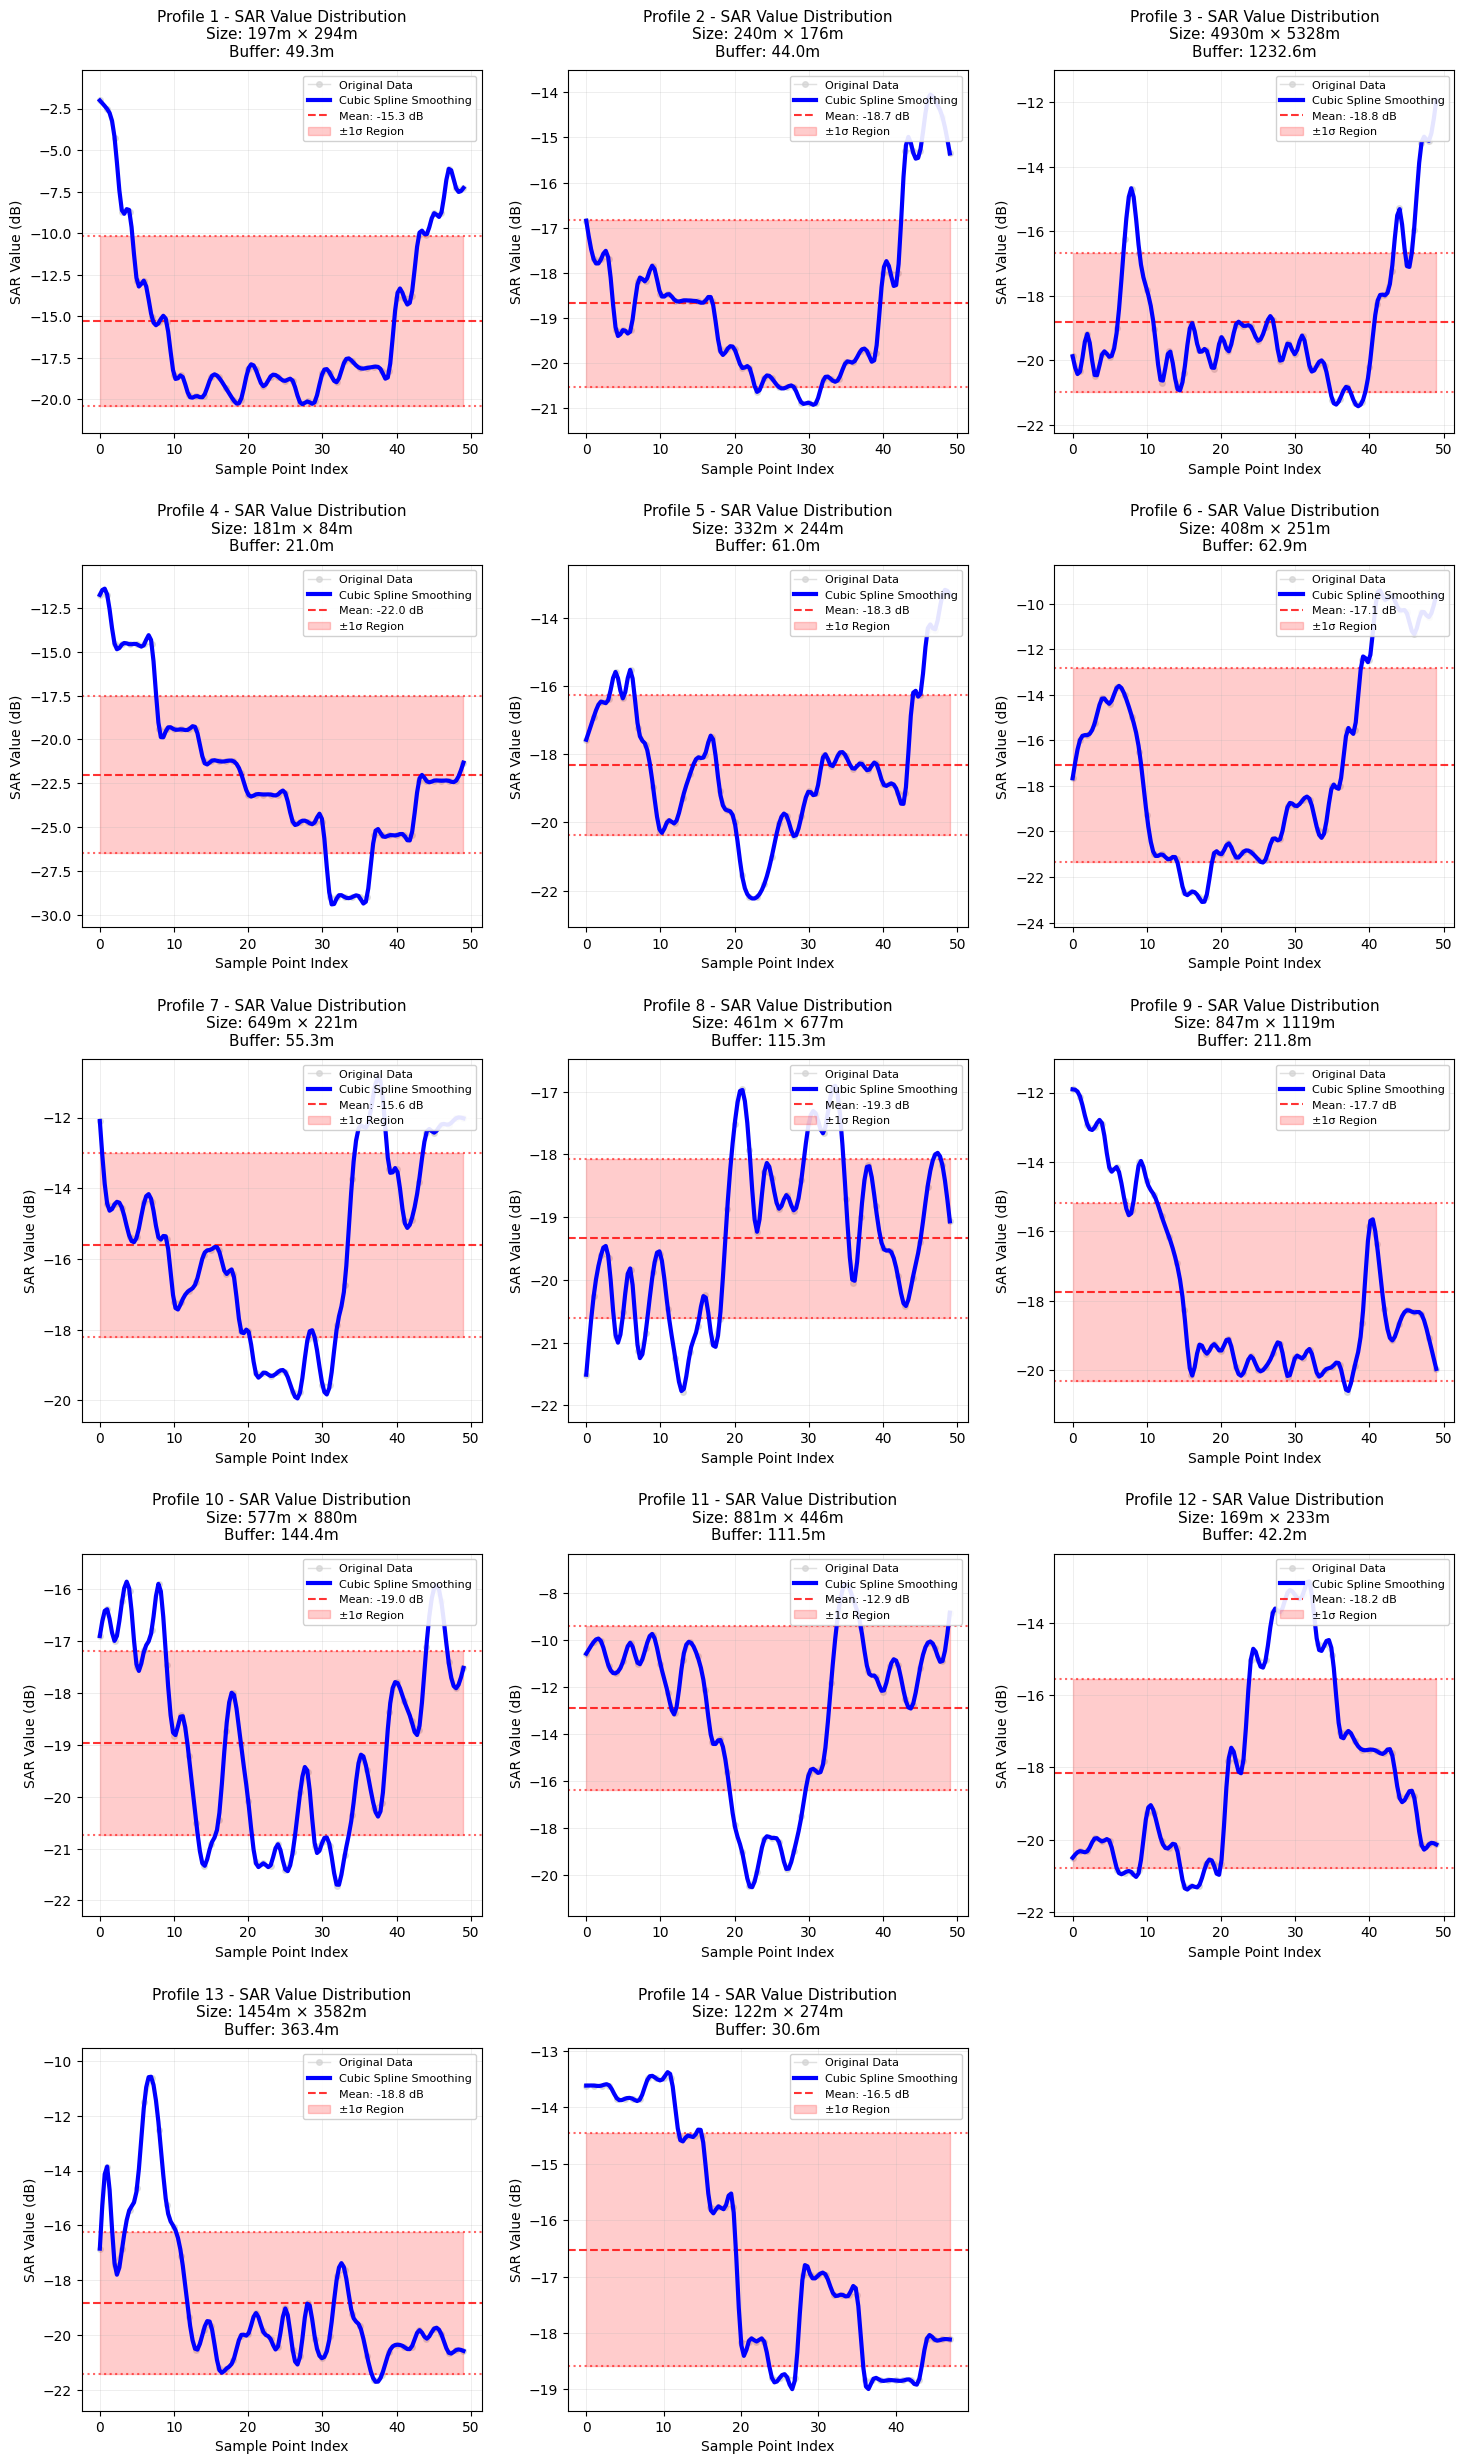

2. Creating combined comparison plot...


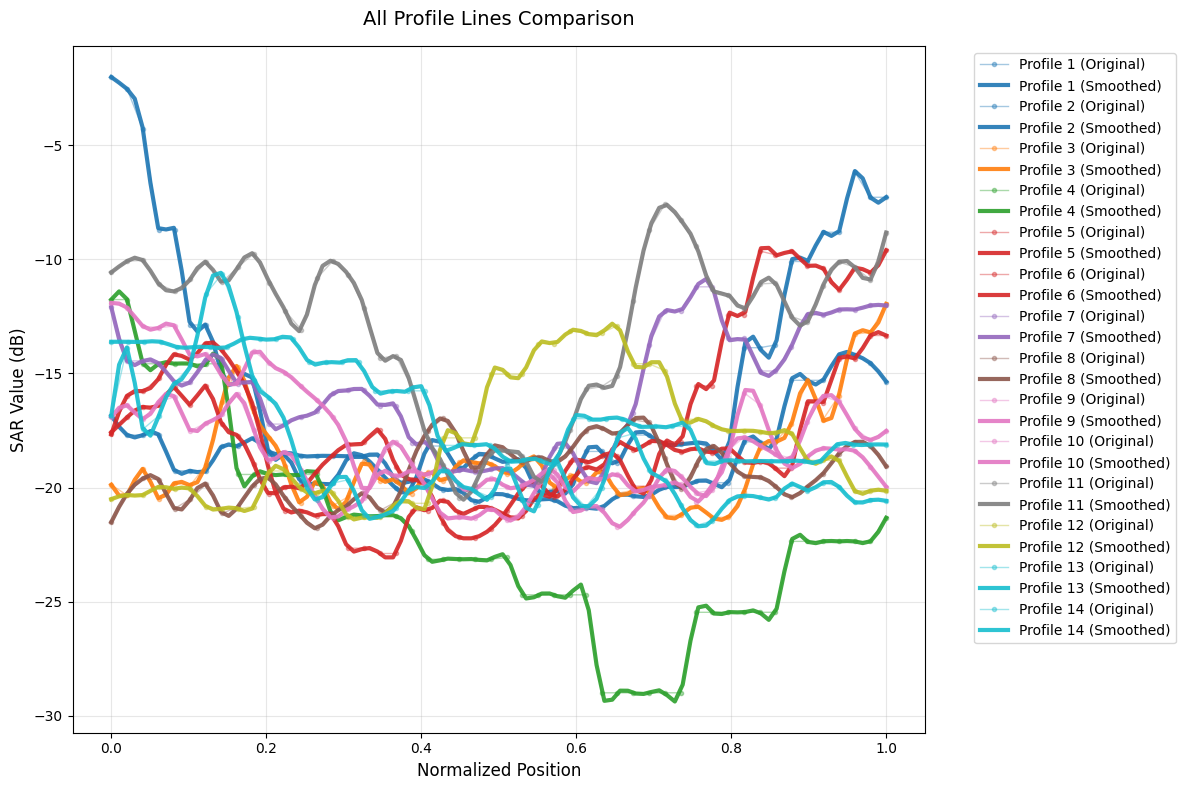

3. Creating advanced analysis plots...


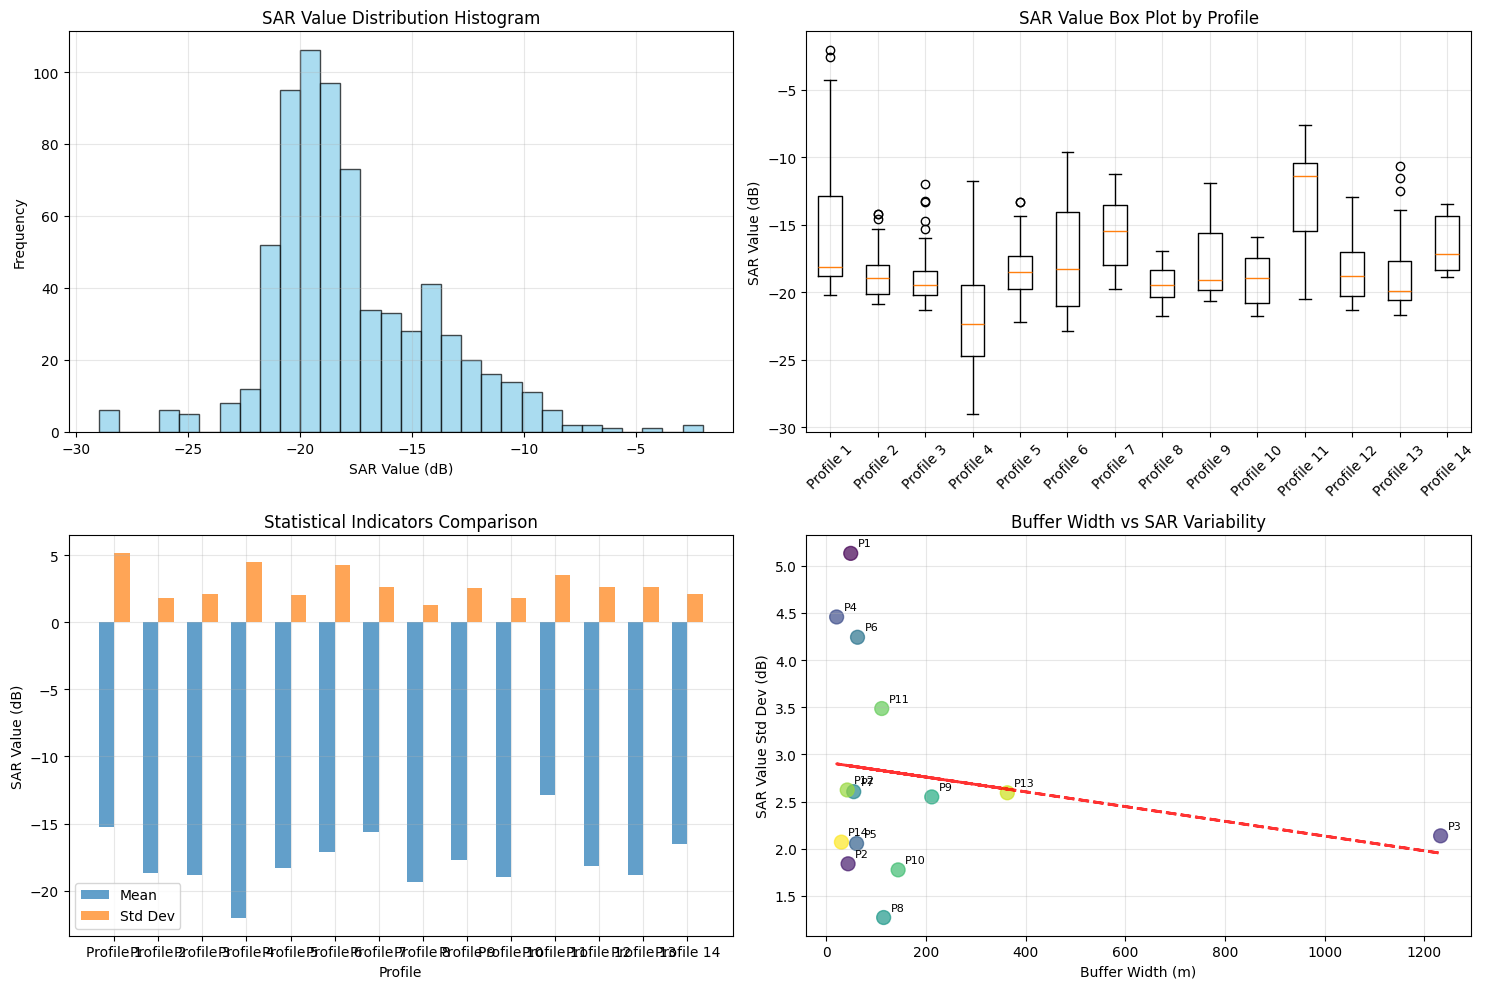


=== Profile Statistics Summary ===
   profile   mean  std    min    max  range  buffer_width
 Profile 1 -15.28 5.13 -20.19  -2.02  18.18         49.26
 Profile 2 -18.68 1.84 -20.87 -14.18   6.69         43.96
 Profile 3 -18.83 2.14 -21.31 -11.95   9.36       1232.58
 Profile 4 -22.00 4.46 -28.99 -11.76  17.22         20.98
 Profile 5 -18.32 2.06 -22.19 -13.34   8.85         60.99
 Profile 6 -17.08 4.24 -22.88  -9.61  13.27         62.87
 Profile 7 -15.61 2.61 -19.75 -11.20   8.55         55.30
 Profile 8 -19.34 1.27 -21.78 -16.96   4.82        115.30
 Profile 9 -17.75 2.55 -20.61 -11.91   8.70        211.80
Profile 10 -18.97 1.78 -21.72 -15.90   5.82        144.36
Profile 11 -12.89 3.49 -20.46  -7.60  12.86        111.46
Profile 12 -18.16 2.62 -21.29 -12.90   8.38         42.19
Profile 13 -18.84 2.59 -21.66 -10.63  11.02        363.39
Profile 14 -16.52 2.07 -18.84 -13.48   5.36         30.60
All visualization charts completed!


In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import pandas as pd

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def create_smooth_profile_plots(mean_profile_results):
    """为每一条均值剖面线创建平滑的像素折线图

    Args:
        mean_profile_results (_type_): 均值剖面线结果列表
    Returns:
        每一条均值剖面线的平滑折线图，包括原始数据点、平滑曲线、均值线、±1标准差区域等
    """
    if not mean_profile_results:
        print("没有提供均值剖面线结果")
        return
    
    
    # 计算子图布局
    n_profiles = len(mean_profile_results)
    cols = min(3, n_profiles) # 最多3列
    rows = (n_profiles + cols - 1) // cols # 计算行数
    
    # 创建图形
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows)) # 创建子图网格
    
    # 处理axes（子图的索引)为一维数组，方便迭代
    if n_profiles== 1:
        axes = [axes] # 只有一个子图时，axes是单个对象，转为列表
    elif rows == 1:
        axes = axes.flatten() # 只有一行时，axes是一维数组，直接扁平化
    else:
        axes = axes.flatten() # 多行多列时，axes是二维数组，扁平化为一维数组
        
    # 设置matplotlib样式
    plt.style.use('default') 
    
    # 遍历每个剖面线结果，为每个创建一个子图
    for idx, result in enumerate(mean_profile_results):
        ax = axes[idx] # 获取当前子图
        
        #从结果字典中提取SAR值数据
        sar_values = np.array(result['mean_values']) #转换为numpy数组便于计算
        sample_indices = np.arange(len(sar_values)) # 创建采样点索引:0,1,2...,n-1
        
        # 绘制原始数据点和连线
        ax.plot(sample_indices, sar_values, 'o-',  # 'o-'表示圆点+实线
                color='lightgray',  # 浅灰色
                alpha=0.7,  # 透明度70%
                linewidth=1,  # 线宽1像素
                markersize=4,  # 标记点大小4像素
                label='Original Data',  # 图例标签
                zorder=1)  # 绘制层次，数值小的在下层
        
        # 使用三次样条插值进行平滑
        if len(sar_values) > 3: #至少需要四个点
            try:
                #创建更密集的插值点 - 原来n个点拓展到3n个点
                x_new = np.linspace(0, len(sar_values)-1, num=len(sar_values)*3) #linspace()在指定范围内生成均匀间隔的数值
                
                # 基于原来的像素索引-sar数据，使用scipy的三次样条插值,生成一个插值函数
                cs = interpolate.CubicSpline(sample_indices, # x坐标（采样点索引)
                                             sar_values, # y坐标（SAR值)
                                            bc_type='natural') # 自然边界条件
                sar_smooth = cs(x_new) # 计算插值点的SAR值
                
                # 绘制平滑曲线
                ax.plot(x_new, sar_smooth, '-', # '-'表示实线
                        color = 'blue', # 蓝色
                        linewidth = 3,
                        label = 'Cubic Spline Smoothing',
                        zorder = 3) # 绘制层次，数值大的在上层
                
            except Exception as e:
                # 如果插值失败，打印错误信息但不中断程序
                print(f"Spline interpolation failed for profile {idx+1}: {e}")
                
        # 计算统计信息
        mean_val = np.mean(sar_values) # 计算均值
        std_val = np.std(sar_values) # 计算标准差
        min_val = np.min(sar_values) # 计算最小值
        max_val = np.max(sar_values) # 计算最大值
        
        # 添加水平参考线
        ax.axhline(y=mean_val,  # 在y=mean_val位置画水平线
                   color='red',  # 红色
                   linestyle='--',  # 虚线样式
                   alpha=0.8,  # 透明度80%
                   label=f'Mean: {mean_val:.1f} dB')  # 图例标签，保留1位小数
        
        # 添加±1标准差的参考线（不加图例，避免图例过多）
        ax.axhline(y=mean_val + std_val, color='red', linestyle=':', alpha=0.6)  # 上界
        ax.axhline(y=mean_val - std_val, color='red', linestyle=':', alpha=0.6)  # 下界
        
        # 填充±1标准差区域
        ax.fill_between(sample_indices,  # x坐标范围
                        mean_val - std_val,  # 下边界
                        mean_val + std_val,  # 上边界
                        alpha=0.2,  # 透明度20%
                        color='red',  # 红色填充
                        label='±1σ Region')  # 图例标签
        
        # 设置子图标题 - 包含剖面线编号和关键信息
        ax.set_title(f'Profile {idx+1} - SAR Value Distribution\n'  # 第一行：标题
                    f'Size: {result["width_meters"]:.0f}m × {result["height_meters"]:.0f}m\n'  # 第二行：矩形尺寸
                    f'Buffer: {result["buffer_width_meters"]:.1f}m',  # 第三行：缓冲区宽度
                    fontsize=11, pad=10)  # 字体大小11，标题与图的间距10
        
        # 设置坐标轴标签
        ax.set_xlabel('Sample Point Index', fontsize=10)  # x轴标签
        ax.set_ylabel('SAR Value (dB)', fontsize=10)  # y轴标签
        
        # 添加网格
        ax.grid(True,  # 启用网格
                alpha=0.3,  # 透明度30%
                linestyle='-',  # 实线样式
                linewidth=0.5)  # 线宽0.5像素
        
        # 设置图例
        ax.legend(loc='upper right',  # 位置：右上角
                  fontsize=8,  # 字体大小8
                  framealpha=0.9)  # 图例框透明度90%
        
        # 动态调整Y轴显示范围
        y_range = max_val - min_val 
        ax.set_ylim(min_val - y_range*0.1, max_val + y_range*0.1)  # 下限为最小值-10%范围，上限为最大值+10%范围
        # 隐藏多余的子图（当剖面线数量不能完全填满网格时）
    for idx in range(n_profiles, len(axes)):
        axes[idx].set_visible(False)  # 设置为不可见
    
    # 调整子图布局，避免重叠
    plt.tight_layout(pad=2.0)  # pad=2.0设置子图间的间距
    
    # 显示图形
    plt.show()
    
def create_combined_profile_plot(mean_profile_results):
    """创建所有剖面线的组合对比图，将所有剖面线显示在同一张图进行比较

    Args:
        mean_profile_results (_type_): _description_
    Returns:
        一张大图，所有剖面线的平滑折线图进行对比
    """
    if not mean_profile_results:
        print("没有提供均值剖面线结果")
        return
    
    # 创建单个大图
    plt.figure(figsize=(12,8))
    
    # 为每个剖面线分配不同颜色
    # np.linspace生成从0到1的均匀间隔的数值，数量为剖面线数量，tab10将这些数组映射到调色板中，生成颜色数组
    colors = plt.cm.tab10(np.linspace(0, 1, len(mean_profile_results)))
    
    # 遍历每个剖面线及对应颜色
    for idx, (result, color) in enumerate(zip(mean_profile_results, colors)):
        sar_values = np.array(result['mean_values'])
        sampled_indices = np.arange(len(sar_values))
        
        # 将索引正规化到0-1范围，便于不同长度剖面线进行比较
        normalized_indices =  sampled_indices / (len(sar_values) - 1) # 索引从0开始，最大值为len-1
        
        # 绘制原始折线数据
        # 绘制原始数据（淡色，用于对比）
        plt.plot(normalized_indices, sar_values, 'o-',
                color=color, alpha=0.4,  # 透明度40%，比较淡
                linewidth=1, markersize=3,
                label=f'Profile {idx+1} (Original)')
        
        # 样条平滑处理
        if len(sar_values) > 3:
            try:
                # 创建正规化的插值点
                x_new = np.linspace(0, 1, len(sar_values)*2)
                cs = interpolate.CubicSpline(normalized_indices, sar_values, bc_type='natural')
                sar_smooth = cs(x_new)
                
                # 绘制平滑曲线（不透明，突出显示）
                plt.plot(x_new, sar_smooth, '-',
                        color=color, linewidth=3, alpha=0.9,
                        label=f'Profile {idx+1} (Smoothed)')
            except:
                pass  # 忽略插值失败的情况
    
    # 设置图表标题和标签
    plt.xlabel('Normalized Position', fontsize=12)  # x轴：正规化位置
    plt.ylabel('SAR Value (dB)', fontsize=12)  # y轴：SAR值
    plt.title('All Profile Lines Comparison', fontsize=14, pad=15)  # 标题
    plt.grid(True, alpha=0.3)  # 添加网格
    
    # 设置图例（放在图外右侧）
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # 自动调整布局
    plt.show()

        
def create_advanced_analysis_plots(mean_profile_results):
    """
    创建进阶分析图表 - 提供更深入的统计分析视图
    """
    if not mean_profile_results:
        return
    
    # 创建2x2的子图网格
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 收集所有数据用于分析
    all_values = []  # 存储所有剖面线的所有SAR值
    profile_stats = []  # 存储每个剖面线的统计信息
    
    # 计算每个剖面线的统计指标
    for idx, result in enumerate(mean_profile_results):
        values = np.array(result['mean_values'])
        all_values.extend(values)  # 将当前剖面线的值添加到总列表
        
        # 创建统计信息字典
        profile_stats.append({
            'profile': f'Profile {idx+1}',
            'mean': np.mean(values),  # 均值
            'std': np.std(values),  # 标准差
            'min': np.min(values),  # 最小值
            'max': np.max(values),  # 最大值
            'range': np.max(values) - np.min(values),  # 值域
            'buffer_width': result['buffer_width_meters']  # 缓冲区宽度
        })
    
    # 转换为pandas DataFrame便于操作
    df_stats = pd.DataFrame(profile_stats)
    
    # 子图1：整体SAR值分布直方图
    ax1.hist(all_values,  # 所有SAR值
             bins=30,  # 分为30个区间
             alpha=0.7,  # 透明度70%
             color='skyblue',  # 天蓝色
             edgecolor='black')  # 黑色边框
    ax1.set_xlabel('SAR Value (dB)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('SAR Value Distribution Histogram')
    ax1.grid(True, alpha=0.3)
    
    # 子图2：各剖面线的箱形图对比
    box_data = [result['mean_values'] for result in mean_profile_results]  # 每个剖面线的数据
    box_labels = [f'Profile {i+1}' for i in range(len(mean_profile_results))]  # 标签
    ax2.boxplot(box_data, labels=box_labels)
    ax2.set_ylabel('SAR Value (dB)')
    ax2.set_title('SAR Value Box Plot by Profile')
    ax2.tick_params(axis='x', rotation=45)  # x轴标签旋转45度
    ax2.grid(True, alpha=0.3)
    
    # 子图3：统计指标柱状图对比
    x_pos = np.arange(len(df_stats))  # x轴位置
    width = 0.35  # 柱子宽度
    # 绘制并排的柱状图
    ax3.bar(x_pos - width/2, df_stats['mean'], width, label='Mean', alpha=0.7)  # 均值
    ax3.bar(x_pos + width/2, df_stats['std'], width, label='Std Dev', alpha=0.7)  # 标准差
    ax3.set_xlabel('Profile')
    ax3.set_ylabel('SAR Value (dB)')
    ax3.set_title('Statistical Indicators Comparison')
    ax3.set_xticks(x_pos)  # 设置x轴刻度位置
    ax3.set_xticklabels(df_stats['profile'])  # 设置x轴刻度标签
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 子图4：缓冲区宽度vs SAR变异性散点图
    ax4.scatter(df_stats['buffer_width'],  # x：缓冲区宽度
               df_stats['std'],  # y：标准差（变异性指标）
               s=100,  # 点的大小
               alpha=0.7,  # 透明度
               c=range(len(df_stats)),  # 颜色映射到索引
               cmap='viridis')  # 使用viridis色彩映射
    ax4.set_xlabel('Buffer Width (m)')
    ax4.set_ylabel('SAR Value Std Dev (dB)')
    ax4.set_title('Buffer Width vs SAR Variability')
    
    # 添加趋势线（如果有多于1个点）
    if len(df_stats) > 1:
        # 使用一次多项式（直线）拟合
        z = np.polyfit(df_stats['buffer_width'], df_stats['std'], 1)
        p = np.poly1d(z)  # 创建多项式函数
        ax4.plot(df_stats['buffer_width'], p(df_stats['buffer_width']),
                "r--", alpha=0.8, linewidth=2)  # 红色虚线
    
    # 为每个散点添加标签
    for i, row in df_stats.iterrows():
        ax4.annotate(f'P{i+1}',  # 标签文本
                    (row['buffer_width'], row['std']),  # 标签位置
                    xytext=(5, 5),  # 文本偏移
                    textcoords='offset points',  # 偏移单位
                    fontsize=8)
    
    ax4.grid(True, alpha=0.3)
    
    # 调整整体布局
    plt.tight_layout()
    plt.show()
    
    # 打印统计表格到控制台
    print("\n=== Profile Statistics Summary ===")
    print(df_stats.round(2).to_string(index=False))  # 保留2位小数，不显示行索引

# 执行可视化的主程序
print("\n=== Creating Mean Profile Line Visualization Charts ===")

# 1. 创建个别剖面线的平滑图
print("1. Creating spline smoothed profile plots...")
create_smooth_profile_plots(mean_profile_results)

# 2. 创建组合对比图
print("2. Creating combined comparison plot...")
create_combined_profile_plot(mean_profile_results)

# 3. 创建进阶分析图
print("3. Creating advanced analysis plots...")
create_advanced_analysis_plots(mean_profile_results)

print("All visualization charts completed!")

## 7.4 均值剖面线梯度计算及梯度点可视化

### 函数1:从均值剖面线结果中计算每个矩形局部阈值
### 函数2：提取计算成功的结果与阈值统计信息
### 函数3：在地图上可视化梯度极值点和阈值计算结果

In [23]:
import numpy as np

def calculate_local_threshold_from_mean_profile(mean_profile_result):
    """
    从均值剖面线结果中计算每个矩形的局部阈值
    原理:
    1. 从均值剖面线中提取SAR序列
    2. 计算一阶梯度，找到最大正梯度和最大负梯度
    3. 通过梯度极值点两侧像素值的均值来确定阈值
    4. 最终阈值为正负梯度阈值的平均值
    Args:
        mean_profile_results: 包含均值剖面线信息的字典
         -'mean_values': SAR值列表
         -'feature': 原始矩形Feature
         -'neg/pos+grad_point_coords': 最正/最负关键点坐标
         -'local_threshold': 局部阈值
         -其他相关属性..
         
    Returns:
        一个包含局部阈值和相关信息的字典
    """
    try:
        # --- 1.数据准备与验证 ---
        sar_values = mean_profile_result.get('mean_values', []) # 获取SAR值列表
        sample_points = mean_profile_result.get('sample_points', []) # 获取采样点坐标列表
        
        # 检查数据有效性
        if not sar_values or len(sar_values) < 3:
            return {
                'success': False,
                'local_threshold':-999,
                'reason':'NotEnoughPoints',
                'error_msg':f'Least need 3 points, actually got {len(sar_values)}'
            }
        
        # --- 2.梯度计算与分析 ---
        #中心差分的一阶梯度计算
        sar_array = np.array(sar_values) 
        gradients = np.gradient(sar_array)
        
        print(f" SAR值范围:[{sar_array.min():.2f}, {sar_array.max():.2f}] dB")
        print(f" 梯度范围: [{gradients.min():.3f}, {gradients.max():.3f}] dB/pixel")
        
        # --- 3.寻找极值梯度位置 ---
        # 为避免边界效应，在除去首尾的梯度中寻找极值
        inner_gradients = gradients[1:-1]
        
        # 寻找最大正/负梯度及其索引
        idx_max_neg_grad = np.argmin(inner_gradients) + 1 #因为进行了边界（开头一个像素）剔除，所以索引需要+1
        idx_max_pos_grad = np.argmax(inner_gradients) + 1
        
        print(f"    最大负梯度: 位置{idx_max_neg_grad}, 值={gradients[idx_max_neg_grad]:.3f}")
        print(f"    最大正梯度: 位置{idx_max_pos_grad}, 值={gradients[idx_max_pos_grad]:.3f}")
        
        # --- 4.计算局部阈值 ---
        # 使用两个梯度极值点与其邻近点的均值作为阈值，两个均值的再均值为最终阈值
        if idx_max_neg_grad > 0:
            thresh_neg = (sar_array[idx_max_neg_grad] + sar_array[idx_max_neg_grad -1]) / 2.0
        else:
            thresh_neg = sar_array[idx_max_neg_grad]    #边界点，无法取前一个点
        
        if idx_max_pos_grad > 0:
            thresh_pos = (sar_array[idx_max_pos_grad] + sar_array[idx_max_pos_grad - 1]) / 2.0
        else:
            thresh_pos = sar_array[idx_max_pos_grad]
            
        # 最终阈值：两个候选阈值的平均
        local_threshold = (thresh_neg + thresh_pos) / 2.0
        
        print(f"    负梯度阈值: {thresh_neg:.2f} dB")
        print(f"    正梯度阈值: {thresh_pos:.2f} dB")
        print(f"    最终局部阈值: {local_threshold:.2f} dB")
        
        # ---5.根据之前的关键采样点提取关键点坐标 ---
        neg_grad_coords = sample_points[idx_max_neg_grad] if idx_max_neg_grad < len(sample_points) else None
        pos_grad_coords = sample_points[idx_max_pos_grad] if idx_max_pos_grad < len(sample_points) else None
        
        return {
            'success': True,
            'local_threshold': local_threshold,
            'thresh_neg': thresh_neg,
            'thresh_pos': thresh_pos,
            'max_neg_gradient': gradients[idx_max_neg_grad],
            'max_pos_gradient': gradients[idx_max_pos_grad],
            'neg_grad_point_coords': neg_grad_coords,
            'pos_grad_point_coords': pos_grad_coords,
            'neg_grad_index': idx_max_neg_grad,
            'pos_grad_index': idx_max_pos_grad,
            'all_gradients': gradients.tolist(),
            'reason': f"成功计算。负梯度阈值={thresh_neg:.2f}, 正梯度阈值={thresh_pos:.2f}"
        }
        
    except Exception as e:
        return {
            'success': False,
            'local_threshold': -999,
            'reason': 'CalculationError',
            'error_msg': str(e)
        }
        
def process_all_profile_thresholds(mean_profile_results):
    """
    处理所有均值剖面线，计算每个矩形的局部阈值,并打印出具体信息，这个函数要在上个函数的基础上运行
    Args:
        mean_profile_results: 包含所有均值剖面线结果的列表
    Returns:
        tuple:成功的阈值结果列表，所有结果的统计信息
    """
    print("\n" + "="*80)
    print("开始批量计算均值剖面线的局部阈值")
    print("="*80)
    print(f"{'Profile ID':<12} | {'Local Threshold':<16} | {'Status':<10} | {'Details'}")
    print("-"*80)
    
    successful_results = []
    failed_results = []
    all_thresholds = []
    
    for idx, profile_result in enumerate(mean_profile_results):
        print(f"\n处理剖面线{idx+1}...")
        
        # 调用阈值计算函数
        threshold_result = calculate_local_threshold_from_mean_profile(profile_result)
        
        # 合并原始剖面线数据和阈值计算结果
        # 这是个大字典，其中属性嵌套小字典
        combined_result = {
            'profile_id' : idx + 1,  # 剖面线ID，int
            'original_profile_data' : profile_result, #原始剖面线数据，字典
            'threshold_calculation' : threshold_result #阈值计算结果，字典
        }
        
        # 根据计算结果分类
        if threshold_result['success']:
            threshold_value = threshold_result['local_threshold'] #提取该矩形的局部阈值
            status = 'SUCCESS'
            details = f"threshold={threshold_value:.2f} dB"
            successful_results.append(combined_result) # 添加到成功列表
            all_thresholds.append(threshold_value) # 仅保存阈值用于统计
        else:
            threshold_value = "N/A" # 失败时无阈值
            status = 'FAILED'
            details = f"Reason: {threshold_result.get('reason','Unknown error')}"
            failed_results.append(combined_result) # 添加到失败列表
            
        # 打印处理结果
        print(f"Profile{idx+1:<5}|{str(threshold_value):<16}|{status:<10}{details}") # 分别打印ID、阈值、状态、详情信息
        
        # 如果成功，打印详细信息
        if threshold_result['success']:
            print(f"    ✓ 负梯度: {threshold_result['max_neg_gradient']:.3f} → 阈值 {threshold_result['thresh_neg']:.2f}")
            print(f"    ✓ 正梯度: {threshold_result['max_pos_gradient']:.3f} → 阈值 {threshold_result['thresh_pos']:.2f}")
            

    print("-" * 80)
    
    # ---统计信息汇总---
    total_profiles = len(mean_profile_results) # 剖面线数量
    success_count = len(successful_results) # 成功数量
    failure_count = len(failed_results) # 失败数量
    
    #继续创建一个字典，存储各个统计值
    statistics = {
        'total_profiles':total_profiles,
        'success_count':success_count,
        'failure_count':failure_count,
        'success_rate': (success_count / total_profiles * 100) if total_profiles > 0 else 0,
        'all_thresholds': all_thresholds
    }
    
    # 如果有成功的阈值，计算统计指标
    if all_thresholds:
        statistics.update({
            'mean_threshold':np.mean(all_thresholds),
            'std_threshold':np.std(all_thresholds),
            'min_threshold':np.min(all_thresholds),
            'max_threshold':np.max(all_thresholds),
            'threshold_range':np.max(all_thresholds) - np.min(all_thresholds)
        })
        print(f"\n阈值统计摘要:")
        print(f"  成功率: {statistics['success_rate']:.1f}% ({success_count}/{total_profiles})")
        print(f"  阈值范围: [{statistics['min_threshold']:.2f}, {statistics['max_threshold']:.2f}] dB")
        print(f"  平均阈值: {statistics['mean_threshold']:.2f} ± {statistics['std_threshold']:.2f} dB")
    else:
        print(f"\n处理结果: 失败率100% (0/{total_profiles})")
    
    print("="*80)
    
    return successful_results, statistics # 返回成功的结果和统计信息
   

def visualize_threshold_points_on_map(successful_results, Map):
    """
    在地图上可视化梯度极值点和阈值计算结果
    
    Args:
        successful_results(list):成功计算阈值的结果列表
        Map(geemap.Map): geemap地图对象
    """
    if not successful_results:
        print("没有成功的阈值计算结果供可视化")
        return
    
    print(f"\n在地图上可视化{len(successful_results)}个剖面线的梯度极值点...")
    
    # 收集所有梯度极值点的坐标，创建两个list
    neg_grad_points = [] #最大负梯度点
    pos_grad_points = [] #最大正梯度点
    
    for result in successful_results: # 遍历每个成功结果(为combined_results的嵌套字典)
        threshold_calc = result['threshold_calculation'] # 提取嵌套字典中的阈值计算结果字典
        
        # 提取正，负梯度极值点坐标到列表中
        neg_coords = threshold_calc.get('neg_grad_point_coords')
        if neg_coords:
            neg_grad_points.append(ee.Feature(ee.Geometry.Point(neg_coords))) # 创建gee矢量类型的点Feature并添加到列表
        pos_coords = threshold_calc.get('pos_grad_point_coords')
        if pos_coords:
            pos_grad_points.append(ee.Feature(ee.Geometry.Point(pos_coords)))
            
    # 创建FeatureCollection并添加到地图
    if neg_grad_points:
        neg_points_fc = ee.FeatureCollection(neg_grad_points)
        Map.addLayer(neg_points_fc,{
            'color':'FF0000',
            'pointSize':8,
            'pointShape':'circle'
        }, 'Max Negative Gradient Points')
        print(f"  ✓ 添加 {len(neg_grad_points)} 个最大负梯度点-red")
        
    if pos_grad_points:
        pos_points_fc = ee.FeatureCollection(pos_grad_points)
        Map.addLayer(pos_points_fc,{
            'color':'0000FF',
            'pointSize':8,
            'pointShape':'circle'
        }, 'Max Positive Gradient Points')
        print(f"  ✓ 添加 {len(pos_grad_points)} 个最大正梯度点-blue")
    
    
    
    
    

        
        
        
        
            
        
   

### 主执行流程

In [24]:
# 检查前提条件
if 'mean_profile_results' not in globals() or not mean_profile_results:
    print("❌ 错误：未找到 'mean_profile_results' 数据")
    print("   请确保您已成功运行了第7.2节的均值剖面线提取代码")
else:
    print(f"✓ 找到 {len(mean_profile_results)} 条均值剖面线，开始计算局部阈值...")
    
    # 执行批量阈值计算
    successful_threshold_results, threshold_statistics = process_all_profile_thresholds(mean_profile_results)
    
    # 在地图上可视化结果
    Map_gradient = geemap.Map()
    Map_gradient.centerObject(roi_choose1, 11)
    if successful_threshold_results:
        visualize_threshold_points_on_map(successful_threshold_results, Map_gradient)
        
        # 将结果保存为全局变量，供后续使用
        global local_threshold_results
        local_threshold_results = successful_threshold_results
        
        print(f"\n🎉 局部阈值计算完成！")
        print(f"   ✓ 成功计算 {len(successful_threshold_results)} 个局部阈值")
        print(f"   ✓ 结果已保存到全局变量 'local_threshold_results'")
        print(f"   ✓ 梯度极值点已在地图上可视化")
        
        # 居中显示到研究区域
        if 'roi_choose1' in globals():
            Map.centerObject(roi_choose1, 12)
    else:
        print("❌ 没有成功计算出任何局部阈值")

print("\n" + "#"*80)
print("# 局部阈值计算模块执行完毕")  
print("#"*80)

# 显示更新后的地图
Map_gradient
        
    

✓ 找到 14 条均值剖面线，开始计算局部阈值...

开始批量计算均值剖面线的局部阈值
Profile ID   | Local Threshold  | Status     | Details
--------------------------------------------------------------------------------

处理剖面线1...
 SAR值范围:[-20.19, -2.02] dB
 梯度范围: [-3.079, 2.212] dB/pixel
    最大负梯度: 位置2, 值=-3.079
    最大正梯度: 位置39, 值=2.212
    负梯度阈值: -3.42 dB
    正梯度阈值: -18.29 dB
    最终局部阈值: -10.86 dB
Profile1    |-10.855510575912103|SUCCESS   threshold=-10.86 dB
    ✓ 负梯度: -3.079 → 阈值 -3.42
    ✓ 正梯度: 2.212 → 阈值 -18.29

处理剖面线2...
 SAR值范围:[-20.87, -14.18] dB
 梯度范围: [-0.851, 1.347] dB/pixel
    最大负梯度: 位置3, 值=-0.782
    最大正梯度: 位置42, 值=1.347
    负梯度阈值: -17.69 dB
    正梯度阈值: -17.99 dB
    最终局部阈值: -17.84 dB
Profile2    |-17.84374618295707|SUCCESS   threshold=-17.84 dB
    ✓ 负梯度: -0.782 → 阈值 -17.69
    ✓ 正梯度: 1.347 → 阈值 -17.99

处理剖面线3...
 SAR值范围:[-21.31, -11.95] dB
 梯度范围: [-1.557, 2.153] dB/pixel
    最大负梯度: 位置9, 值=-1.557
    最大正梯度: 位置7, 值=2.153
    负梯度阈值: -15.69 dB
    正梯度阈值: -17.62 dB
    最终局部阈值: -16.65 dB
Profile3    |-16.65108077

Map(center=[39.406978411144074, -0.3934475000027648], controls=(WidgetControl(options=['position', 'transparen…

# 8.结合局部最优和全局最优的洪水提取

## 8.1 过滤阈值计算结果太大的矩形

In [29]:
def filter_threshold_results(successful_threshold_results, threshold_limit):
    """
    过滤局部阈值结果，移除阈值大于指定限制的矩形
    
    Args:
        successful_threshold_results (dict): 成功计算阈值的结果嵌套字典
        threshold_limit (float): 阈值上限，单位dB
    Returns:
        filtered_results(dict): 过滤后的结果嵌套字典
        statistics(dict): 过滤后的结果列表，统计信息字典
    """
    print(f"\n--- start filtering local threshold(remove threshold > {threshold_limit}db)")
    print("="*80)
    print(f"{'Profile ID':<12} | {'Local Threshold':<16} | {'Status':<10} | {'Action'}")
    print("-"*80)
    
    filtered_results = [] # 存储通过过滤的结果
    removed_results = [] # 存储被移除的结果
    valid_thresholds = [] # 存储通过过滤的阈值，用于统计
    
    for result in successful_threshold_results: # 遍历每个成功结果里面的嵌套字典
        profile_id = result['profile_id'] # 提取剖面线ID,int
        threshold_calc = result['threshold_calculation'] # 提取阈值计算结果字典,dict
        local_threshold = threshold_calc['local_threshold'] # 提取局部阈值,float
        
        if local_threshold <= threshold_limit:
            # 保留当前矩形
            filtered_results.append(result)
            valid_thresholds.append(local_threshold) # 添加到有效阈值列表
            status = "KEPT"
            action = f"Valic threshold: {local_threshold:.2f} "
        else:
            # 移除矩形
            removed_results.append(result)
            status = "REMOVED"
            action = f"Threshold {local_threshold:.2f} > {threshold_limit}"
        print(f"Profile{profile_id:<7} | {local_threshold:<16.2f} | {status:<10} | {action}")
    
    print("-"*80)
    print(f"过滤结果:")
    print(f"  ✓ 保留矩形: {len(filtered_results)} 个")
    print(f"  ✗ 移除矩形: {len(removed_results)} 个")
    
    if valid_thresholds:
        statistics = {
            'total_kept': len(filtered_results),
            'total_removed': len(removed_results),
            'valid_thresholds': valid_thresholds,
            'mean_threshold': np.mean(valid_thresholds),
            'std_threshold': np.std(valid_thresholds),
            'min_threshold': np.min(valid_thresholds),
            'max_threshold': np.max(valid_thresholds)
        }
        print(f"  阈值统计: 均值={statistics['mean_threshold']:.2f}, "
              f"范围=[{statistics['min_threshold']:.2f}, {statistics['max_threshold']:.2f}] dB")
    else:
        statistics = {
            'total_kept': 0,
            'total_removed': len(removed_results),
            'valid_thresholds': [],
            'mean_threshold': None
        }
        print("  ⚠️  警告：没有任何矩形通过阈值过滤")
    
    print("="*80)
    return filtered_results, statistics
        

## 8.2 自适应洪水提取

In [30]:
def create_adaptive_flood_extraction(filtered_threshold_results, flood_image, roi_choose1):
    """
    创建自适应洪水提取:矩形内部使用阈值，外部使用全局平均阈值
    Args:
        filtered_threshold_results (dict): 过滤阈值后的嵌套字典
        flood_image (ee.Image): 用于洪水提取的SAR影像
        roi_choose1 (ee.Geometry): 研究区域
    """
    print(f"\n--- 开始自适应洪水提取 ---")
    print("="*60)
    
    if not filtered_threshold_results:
        print("❌ 错误：没有有效的局部阈值结果进行洪水提取")
        return None, None
    
    # --- 1.计算全局平均阈值 ---
    local_thresholds = [
        result['threshold_calculation']['local_threshold'] 
        for result in filtered_threshold_results # 提取所有局部阈值到列表中
    ]
    
    # 计算全局平均阈值
    global_average_threshold = np.mean(local_thresholds)
    
    print(f"步骤1: 计算全局平均阈值")
    print(f"  ✓ 使用 {len(local_thresholds)} 个有效局部阈值")
    print(f"  ✓ 全局平均阈值: {global_average_threshold:.2f} dB")
    print(f"  ✓ 局部阈值范围: [{min(local_thresholds):.2f}, {max(local_thresholds):.2f}] dB")
    
    # --- 2.为每个矩形创建局部洪水淹没掩模 ---
    print(f"\n步骤2: 为每个矩形应用局部阈值")
    
    local_flood_images = []
    rectangle_geometries = []
    
    for i,result in enumerate(filtered_threshold_results): # 遍历每个成功结果里面的嵌套字典
        profile_id = result['profile_id'] # 提取剖面线ID,int
        threshold_calc = result['threshold_calculation'] # 提取阈值计算结果字典,dict
        local_threshold = threshold_calc['local_threshold'] # 提取局部阈值,float
        rectangle_feature = result['original_profile_data']['feature'] # 提取原始矩形Feature,ee.Feature
        
        # 获取矩形的几何形状
        rectangle_geom = rectangle_feature.geometry()
        rectangle_geometries.append(rectangle_geom) # 保存矩形几何用于后续可视化
        
        # 在该矩形内应用局部阈值
        # 创建矩形内的洪水掩模
        local_flood_mask = flood_image.lt(local_threshold) # SAR值低于局部
        
        # 将洪水掩模裁剪到当前矩形范围
        local_flood_clipped = local_flood_mask.clip(rectangle_geom).selfMask() # selfMask()将非洪水区域设为透明
        local_flood_images.append(local_flood_clipped) # 这个列表包含了所有的局部影像-即只有矩形内的洪水为1,其他区域为0或无值
        
        print(f"  Profile {profile_id}: 局部阈值 {local_threshold:.2f} dB → 矩形内洪水提取")
    
    # --- 3.合并所有局部洪水图 ---
    print(f"\n步骤3：合并所有矩形内的局部洪水图")
    
    # 将所有局部洪水图像合并
    if len(local_flood_images) == 1:
        all_local_floods = local_flood_images[0]
    else:
        local_floods_collection = ee.ImageCollection(local_flood_images) # 把之前的局部影像聚合为一个影像集合
        all_local_floods = local_floods_collection.mosaic() # 使用mosaic方法合并影像集合,即在每个像素取最大值
    
    print(f"  ✓ 合并了 {len(local_flood_images)} 个局部洪水图像")
    
    # --- 4.创建全局矩形区域淹没 ---
    print(f"\n步骤4：创建全局矩形区域的洪水淹没")
    
    # 将所有矩形几何体合并为一个FeatureCollection
    
    rectangles_fc = ee.FeatureCollection([
        ee.Feature(geom) for geom in rectangle_geometries
    ])
    
    # 创建一个表示所有矩形区域的掩膜
    # 在矩形内部值为1，外部值为0
    rectangles_mask = ee.Image().byte().paint(rectangles_fc, 1).clip(roi_choose1)
    
    print(f"  ✓ 创建 {len(rectangle_geometries)} 个矩形的合并掩膜")
    
    # --- 5. 对矩形外部区域应用全局平均阈值 ---
    print(f"\n步骤5: 对矩形外部区域应用全局平均阈值")
    
    # 在整个研究区域应用全局阈值
    global_flood_mask = flood_image.lt(global_average_threshold)
    
    # 只保留矩形外部的全局洪水（矩形内部设为0）
    # 矩形外部：rectangles_mask = 0，矩形内部：rectangles_mask = 1
    global_flood_outside = global_flood_mask.where(rectangles_mask.eq(1), 0)
    
    print(f"  ✓ 全局阈值 {global_average_threshold:.2f} dB 应用于矩形外部区域")
    
    # --- 6. 合并局部和全局洪水图 ---
    print(f"\n步骤6: 合并局部和全局洪水图")
    
    # 将局部洪水图的掩膜移除，用0填充未掩膜区域
    all_local_floods_unmasked = all_local_floods.unmask(0)
    
    # 将局部洪水（矩形内）和全局洪水（矩形外）相加
    global_flood_outside_unmasked = global_flood_outside.unmask(0) # 同样用0填充未掩膜区域
    final_flood_map = all_local_floods_unmasked.add(global_flood_outside_unmasked)
    
    # 将结果限制在研究区域内
    final_flood_map = final_flood_map.clip(roi_choose1).selfMask() # selfMask（）将像素值为0的区域设为透明
    
    print(f"  ✓ 成功合并局部洪水图和全局洪水图")
    
    # --- 7. 创建提取信息 也是一个字典类型 ---
    extraction_info = {
        'num_rectangles': len(filtered_threshold_results), # int
        'local_thresholds': local_thresholds, # list of float
        'global_average_threshold': global_average_threshold, # float
        'threshold_range': [min(local_thresholds), max(local_thresholds)], # list of float
        'extraction_strategy': 'Adaptive: Local thresholds inside rectangles, Global average outside' # str
    }
    
    print(f"\n✅ 自适应洪水提取完成！")
    print(f"  策略: 矩形内部使用局部阈值，外部使用全局平均阈值")
    print(f"  矩形数量: {extraction_info['num_rectangles']}")
    print(f"  全局阈值: {extraction_info['global_average_threshold']:.2f} dB")
    print("="*60)
    
    return final_flood_map, extraction_info
        
    
    
    

In [34]:
# 可视化最终的洪水提取结果函数
def visualize_final_flood_results(final_flood_map, extraction_info, filtered_threshold_results, roi_choose1):
    """
    可视化最终的洪水提取结果
    Args:
        final_flood_map:最终洪水图(ee.Image)
        extraction_info:提取信息(dict)
        filtered_threshold_results(dict):过滤后的阈值结果嵌套字典
        roi_choose1:研究区域(ee.Geometry)
    """
    print(f"\n--- 可视化最终洪水提取结果")
    Map_final = geemap.Map()
    Map_final.centerObject(roi_choose1, 11)
    
    # 添加原始SAR影像作为底图
    Map_final.addLayer(flood_image,{'min':-25,'max':5},'SAR Image(VV)',False)
    flood_vis = {
        'palette':['#0066CC'], # 深蓝色,需要使用列表而不是集合
        'opacity':0.8
    }
    
    # 添加洪水结果影像
    Map_final.addLayer(final_flood_map, flood_vis, 'Final Flood Map', True)
    
    # 添加矩形边界以显示局部阈值应用区域
    #  首先收集矩形
    rectangle_features = []
    for result in filtered_threshold_results:
        original_data = result['original_profile_data']
        rectangle_feature = original_data['feature']
        rectangle_features.append(rectangle_feature)
    
    # 然后转为FeatureCollection，并通过paint方法绘制边界
    if rectangle_features:
        rectangles_fc = ee.FeatureCollection(rectangle_features)
        rectangle_outline = ee.Image().byte().paint(rectangles_fc,0,2)
        Map_final.addLayer(rectangle_outline,{
            'palette':'FFFF00' # 黄色
        }, 'Rectangles Outlines', True)
        print(f"  ✓ 显示 {len(rectangle_features)} 个局部阈值应用区域（黄色边框）")
    
    # 添加梯度极值点
    neg_grad_points = []
    pos_grad_points = []
    
    for result in filtered_threshold_results:
        threshold_calc = result['threshold_calculation']
        
        neg_coords = threshold_calc.get('neg_grad_point_coords')
        if neg_coords:
            neg_grad_points.append(ee.Feature(ee.Geometry.Point(neg_coords)))
            
        pos_coords = threshold_calc.get('pos_grad_point_coords')
        if pos_coords:
            pos_grad_points.append(ee.Feature(ee.Geometry.Point(pos_coords)))
    
    if neg_grad_points:
        neg_points_fc = ee.FeatureCollection(neg_grad_points)
        Map_final.addLayer(neg_points_fc, {
            'color': 'FF0000',
            'pointSize': 6,
            'pointShape': 'circle'
        }, 'Negative Gradient Points')
        print(f"  ✓ 显示 {len(neg_grad_points)} 个负梯度极值点（红色）")
    
    if pos_grad_points:
        pos_points_fc = ee.FeatureCollection(pos_grad_points)
        Map_final.addLayer(pos_points_fc, {
            'color': '0000FF',
            'pointSize': 6,
            'pointShape': 'circle'
        }, 'Positive Gradient Points')
        print(f"  ✓ 显示 {len(pos_grad_points)} 个正梯度极值点（蓝色）")
    
    # 打印提取统计信息
    print(f"\n📊 最终洪水提取统计信息:")
    print(f"  提取策略: {extraction_info['extraction_strategy']}")
    print(f"  局部阈值矩形数量: {extraction_info['num_rectangles']}")
    print(f"  全局平均阈值: {extraction_info['global_average_threshold']:.2f} dB")
    print(f"  局部阈值范围: [{extraction_info['threshold_range'][0]:.2f}, {extraction_info['threshold_range'][1]:.2f}] dB")
    
    # 显示图例说明
    print(f"\n🗺️ 地图图层说明:")
    print(f"  🔵 深蓝色区域: 最终洪水淹没范围")
    print(f"  🟨 黄色边框: 应用局部阈值的矩形区域")
    print(f"  🔴 红色点: 负梯度极值点")
    print(f"  🔵 蓝色点: 正梯度极值点")
    print(f"  📍 矩形内: 使用各自的局部阈值")
    print(f"  📍 矩形外: 使用全局平均阈值 {extraction_info['global_average_threshold']:.2f} dB")
    
    return Map_final
        
        
        
    
    
    

In [35]:
# 主执行流程：自适应洪水提取
# ==============================================================================

print("\n" + "#"*80)
print("# 第8节：结合局部最优和全局最优的洪水提取")
print("#"*80)

# 检查前提条件
if 'local_threshold_results' not in globals() or not local_threshold_results:
    print("❌ 错误：未找到 'local_threshold_results' 数据")
    print("   请确保您已成功运行了第7.4节的局部阈值计算代码")
else:
    print(f"✓ 找到 {len(local_threshold_results)} 个局部阈值结果")
    
    # 步骤1: 过滤阈值大于-8的矩形
    filtered_results, filter_statistics = filter_threshold_results(
        local_threshold_results, 
        threshold_limit=-8
    )
    
    if not filtered_results:
        print("❌ 所有矩形都被过滤掉了，无法进行洪水提取")
        print("   建议：调整阈值过滤条件或检查局部阈值计算结果")
    else:
        # 步骤2: 执行自适应洪水提取
        final_flood_map, extraction_info = create_adaptive_flood_extraction(
            filtered_results,
            flood_image,
            roi_choose1
        )
        
        if final_flood_map is not None:
            # 步骤3: 可视化最终结果
            Map_final_flood = visualize_final_flood_results(
                final_flood_map,
                extraction_info,
                filtered_results,
                roi_choose1
            )
            
            # 保存最终结果为全局变量
            global final_flood_extraction_results
            final_flood_extraction_results = {
                'flood_map': final_flood_map,
                'extraction_info': extraction_info,
                'filtered_results': filtered_results,
                'filter_statistics': filter_statistics
            }
            
            print(f"\n🎉 自适应洪水提取成功完成！")
            print(f"   ✓ 最终洪水图已生成")
            print(f"   ✓ 结果已保存到全局变量 'final_flood_extraction_results'")
            print(f"   ✓ 地图已更新并可视化")
            
        else:
            print("❌ 洪水提取过程中出现错误")

print("\n" + "#"*80)
print("# 自适应洪水提取模块执行完毕")
print("#"*80)

# 显示最终结果地图
Map_final_flood


################################################################################
# 第8节：结合局部最优和全局最优的洪水提取
################################################################################
✓ 找到 14 个局部阈值结果

--- start filtering local threshold(remove threshold > -8db)
Profile ID   | Local Threshold  | Status     | Action
--------------------------------------------------------------------------------
Profile1       | -10.86           | KEPT       | Valic threshold: -10.86 
Profile2       | -17.84           | KEPT       | Valic threshold: -17.84 
Profile3       | -16.65           | KEPT       | Valic threshold: -16.65 
Profile4       | -21.78           | KEPT       | Valic threshold: -21.78 
Profile5       | -18.74           | KEPT       | Valic threshold: -18.74 
Profile6       | -16.72           | KEPT       | Valic threshold: -16.72 
Profile7       | -14.25           | KEPT       | Valic threshold: -14.25 
Profile8       | -18.84           | KEPT       | Valic threshold: -18.84 
Profile9 

Map(center=[39.406978411144074, -0.3934475000027648], controls=(WidgetControl(options=['position', 'transparen…